In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import LucaM185
device = torch.device("cuda:0")


In [2]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [3]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

vocab_size = len(texttoint)
sequence_length = 20

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[2000:, :-1]
labels = sequences[2000:, -1]
val_inputs = sequences[:2000, :-1]
val_labels = sequences[:2000, -1]

Multi-Head Attention (MHA) uses multiple attention heads to process different parts of the input simultaneously along the embedding dimension. Each head calculates attention independently by applying different projections of the queries, keys, and values. The outputs from each head are then concatenated and transformed through a final linear layer, allowing the model to capture various relationships and patterns.

Note: this is a very slow implemenation, it's made to simplify the intuition behind MHA. Pytorch implementation of MHA is far better

Epoch ___0 - Loss: 4.244
Epoch _600 - Loss: 1.869
Epoch 1200 - Loss: 1.774
Epoch 1800 - Loss: 1.720
Epoch 2400 - Loss: 1.596
Epoch 3000 - Loss: 1.546
Epoch 3600 - Loss: 1.523
Epoch 4200 - Loss: 1.542
Epoch 4800 - Loss: 1.496
Epoch 5400 - Loss: 1.438


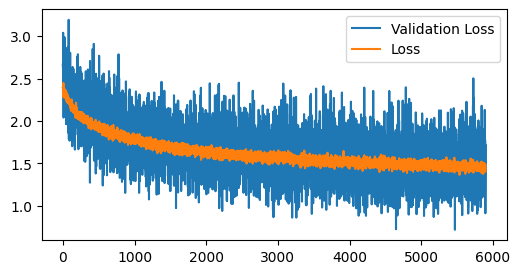

In [13]:
class Attention(nn.Module):  
    def __init__(self, emb_size):
        super(Attention, self).__init__()
        self.head_size = head_size = emb_size

        self.keys = nn.Linear(emb_size, head_size)
        self.queries = nn.Linear(emb_size, head_size)
        self.values = nn.Linear(emb_size, head_size) 
        self.rvalues = nn.Linear(head_size, emb_size)

    def forward(self, x, mask=False):
        k = self.keys(x)
        q = self.queries(x)
        v = self.values(x)

        similarity = k @ q.transpose(-2, -1)/(self.head_size**0.5)
        if mask: similarity[torch.tril(torch.ones_like(similarity)) == 0] = float("-inf")
        similarity = torch.softmax(similarity, dim = 1)
        
        attention = similarity @ v 
        attention = self.rvalues(attention)
        return attention
    
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, n_heads=8):
        super().__init__()
        head_size = emb_size//n_heads

        self.heads = nn.ModuleList([Attention(head_size, head_size) for _ in range(n_heads)])

    def forward(self, x):  
        assert x.dim() == 3
        emb_size = x.shape[-1]
        step = emb_size//self.n_heads

        x = x.view(x.shape[0], x.shape[1], self.n_heads, step)
        x = x.transpose(1, 2)  

        outputs = []
        for i in range(self.n_heads):
            outputs.append(self.heads[i](x[:, i, :, :]))  
        outputs = torch.cat(outputs, dim=-1)  

        return outputs

class FullyConnected(nn.Module):  
    def __init__(self, in_size, out_size, hidden_size, n_layers):
        super(FullyConnected, self).__init__()

        self.fc1 = nn.Linear(in_size, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        for fc in self.fcx:
            x = x + F.gelu(fc(x)) 
        x = self.fc2(x)
        return x

    
class Block(nn.Module): 
    def __init__(self, emb_size, head_size, hidden_size, n_layers, attention):
        super().__init__()
        self.emb_size = emb_size
        self.head_size = head_size

        self.prenorm1 = nn.LayerNorm(emb_size)
        self.att = attention(emb_size)
        self.prenorm2 = nn.LayerNorm(emb_size)
        self.fc = FullyConnected(emb_size, emb_size, hidden_size, n_layers)

    def forward(self, x):          
        x = self.prenorm1(x)
        x = x + self.att(x) 
        x = self.prenorm2(x)
        x = x + self.fc(x)
    
        return x
    
class Transformer(nn.Module): 
    def __init__(self, vocab_size, emb_size, n_blocks, head_size, hidden_size, n_layers, attention):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb = nn.Embedding(sequence_length, emb_size)
        
        self.blocks = nn.ModuleList([Block(emb_size, head_size, hidden_size, n_layers, attention) for _ in range(n_blocks)])
        self.LinOut = nn.Linear(emb_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x) + self.posemb(torch.arange(x.size(1)).to(x.device))

        for block in self.blocks:
            x = block(x)
            
        x = self.LinOut(x)
        return x[:, -1]


device = torch.device("cuda:0")
model = Transformer(vocab_size=vocab_size, emb_size=64, n_blocks=8, head_size=64, hidden_size=64, n_layers=2, attention=Attention(64)).to(device)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

epochs = 6000
batch_size = 2048
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))

        pred = model(val_inputs[indexes].to(device))
        loss = F.cross_entropy(pred, val_labels[indexes].to(device))
        vlossi.append(loss.item())
        
plt.figure(figsize=(6, 3))  
plt.plot(vlossi[100:], label='Validation Loss')
plt.plot(lossi[100:], label='Loss')
plt.legend()

# Using the Pytorch implementation 

Number of parameters: 0.08M
Epoch ___0 - Loss: 4.190
Epoch _600 - Loss: 2.040
Epoch 1200 - Loss: 1.908
Epoch 1800 - Loss: 1.918
Epoch 2400 - Loss: 1.769
Epoch 3000 - Loss: 1.741
Epoch 3600 - Loss: 1.739
Epoch 4200 - Loss: 1.721
Epoch 4800 - Loss: 1.692
Epoch 5400 - Loss: 1.639


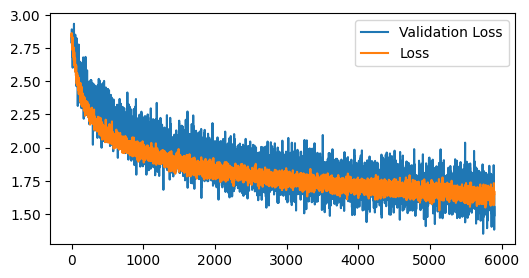

In [14]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.attention = torch.nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=0.0)

    def forward(self, x, mask=None):
        x = x.permute(1, 0, 2)
        x, _ = self.attention(x, x, x, attn_mask=mask)
        x = x.permute(1, 0, 2)
        return x
    
class Block(nn.Module): 
    def __init__(self, emb_size, head_size, hidden_size, n_layers, n_heads):
        super().__init__()
        self.emb_size = emb_size
        self.head_size = head_size

        self.norm = nn.LayerNorm(emb_size)
        self.att = MultiHeadAttention(emb_size, n_heads)
        self.fc = FullyConnected(emb_size, emb_size, hidden_size, n_layers)

    def forward(self, x):          
        x = x + self.att(self.norm(x)) 
        x = x + self.fc(self.norm(x))
    
        return x
    
class Transformer(nn.Module): 
    def __init__(self, vocab_size, emb_size, n_blocks, head_size, hidden_size, n_layers, n_heads):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb = nn.Embedding(sequence_length, emb_size)

        self.blocks = nn.ModuleList([Block(emb_size, head_size, hidden_size, n_layers, n_heads) for _ in range(n_blocks)])
        self.LinOut = nn.Linear(emb_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x) + self.posemb(torch.arange(x.size(1)).to(x.device))

        for block in self.blocks:
            x = block(x)
            
        x = self.LinOut(x)
        return x[:, -1]


device = torch.device("cuda:0")
model = Transformer(vocab_size=vocab_size, emb_size=64, n_blocks=2, head_size=64, hidden_size=64, n_layers=2, n_heads=4).to(device)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

epochs = 6000
batch_size = 2048
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))

        pred = model(val_inputs[indexes].to(device))
        loss = F.cross_entropy(pred, val_labels[indexes].to(device))
        vlossi.append(loss.item())

plt.figure(figsize=(6, 3))  
plt.plot(vlossi[100:], label='Validation Loss')
plt.plot(lossi[100:], label='Loss')
plt.legend()


### Mixture of Experts (MoE)

Models typically encode information in their weights, but not all weights are necessary for every task. For example, if a set of weights primarily encodes city names, they are unnecessary when the task involves solving a quadratic equation.

This leads to the idea of using multiple sets of weights that the model can choose from dynamically, enabling more efficient computation. For instance, the Mistral Mixture of Experts model employs 8 sets of 7B parameters, but only 13B parameters are active at any given time, offering a 3-4x speedup over a similar model without MoE, with minimal impact on performance. GPT-4 also uses an MoE approach, combining 16 experts of 110B parameters each.

However, this requires additional infrastructure, like a router that decides which experts to activate, and may require human input to determine how experts should be trained. Empirically, the way experts are chosen can be opaque, and it's not trivial to prevent a single expert from dominating, leaving the others underutilized.

In [7]:
act = F.gelu

class FullyConnected(nn.Module):
    def __init__(self, in_size, out_size, hidden_size):
        super(FullyConnected, self).__init__()
        self.LayerNorm = nn.LayerNorm(in_size)

        self.fc1 = nn.Linear(in_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        x = self.LayerNorm(x)
        x = act(self.fc1(x))
        x = act(self.fc2(x))
        x = self.out(x)
        return x

class MoE(nn.Module):
    def __init__(self, in_size, out_size, hidden_size, depth=4, n_experts=5):
        super(MoE, self).__init__()
        self.LayerNorm = nn.LayerNorm(in_size)

        self.fcin = nn.Linear(20, n_experts)
        self.experts = nn.ModuleList(FullyConnected(in_size, out_size, hidden_size) for _ in range(n_experts))
        self.fcout = nn.Linear(hidden_size, out_size)

    def forward(self, x, chosen_expert=None):
        
        experts = act(self.fcin(x[:, :, 0]))
        choice = torch.multinomial(torch.softmax(experts, 1), 1)[:, 0]
        
        if chosen_expert is None: # It might be that i goth this the other way around, doesnt matter if depth and n_experts are the same
            for n, expert in enumerate(self.experts):
                x[choice==n] = expert(x[choice==n])
        else:
            x = self.experts[chosen_expert](x)
        
        x = self.fcout(x)
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.attention = torch.nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=0.0)

    def forward(self, x, mask=None):
        x = x.permute(1, 0, 2)
        x, _ = self.attention(x, x, x, attn_mask=mask)
        x = x.permute(1, 0, 2)
        return x
    
class Block(nn.Module):
    def __init__(self, emb_size, head_size, hidden_size, n_layers, n_heads, n_experts):
        super().__init__()

        self.norm = nn.LayerNorm(emb_size)
        self.att = MultiHeadAttention(emb_size, n_heads)
        self.MoE = MoE(in_size=emb_size, out_size=emb_size, hidden_size=hidden_size, depth=n_layers, n_experts=n_experts)


    def forward(self, x, chosen_expert=None): 

        x = x + self.att(self.norm(x)) 
        x = x + self.MoE(self.norm(x), chosen_expert)

        return x

class Transformer(nn.Module):
    def __init__(self, vocab_size, emb_size=64, n_blocks=8, head_size=64, hidden_size=64, n_layers=2, n_heads=4, n_experts=8):
        super(Transformer, self).__init__()

        self.pemb = nn.Embedding(sequence_length, emb_size)
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.blocks = nn.ModuleList([Block(emb_size, head_size, hidden_size, n_layers, n_heads, n_experts) for i in range(n_blocks)])
        self.lout = FullyConnected(in_size=emb_size, out_size=vocab_size, hidden_size=hidden_size)

    def forward(self, x, chosen_expert=None):
        x = self.emb(x)
        pemb = self.pemb(torch.arange(sequence_length).to(device))
        
        x = x + pemb
        
        for block in self.blocks:
            x = x + block(x, chosen_expert=chosen_expert)
        
        x = self.lout(x)
        return x[:, -1]

model = Transformer(vocab_size=65, emb_size=64, n_blocks=8, head_size=64, hidden_size=64, n_layers=2, n_heads=4, n_experts=4).to(device)

lossi = []
vlossi = []
print("Millions of parameters: ", round(sum(p.numel() for p in model.parameters() if p.requires_grad)/1000000, 2))

Millions of parameters:  0.59


In [8]:
%%time
epochs = 6000
batch_size = 2048
print("Percent of dataset: ", epochs*batch_size / inputs.shape[0])

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(loss.item())

    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))

        pred = model(val_inputs[indexes].to(device))
        loss = F.cross_entropy(pred, val_labels[indexes].to(device))
        vlossi.append(loss.item())

Percent of dataset:  11.036732523601705
4.189597129821777
2.1590943336486816
2.0090765953063965
1.871472716331482
1.7769804000854492
1.750587821006775


KeyboardInterrupt: 

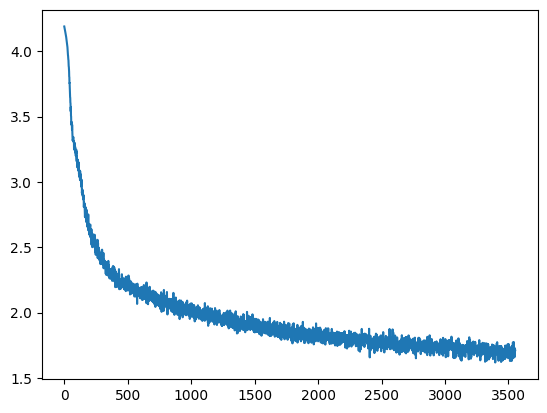

In [9]:
plt.plot(torch.tensor(lossi[::]).view(-1, 1).mean(1))

In [10]:
# val accuracy

pred = model(val_inputs.to(device))
pred = torch.argmax(pred, dim=1)
val_labels = val_labels.to(device)
acc = (pred == val_labels).float().mean()
print("Validation accuracy of MoE: ", acc)

for chosen in range(8):
    pred = model(val_inputs.to(device), chosen_expert=chosen)
    pred = torch.argmax(pred, dim=1)
    val_labels = val_labels.to(device)
    acc = (pred == val_labels).float().mean()
    print("Validation accuracy of expert", chosen, ": ", acc)


Validation accuracy of MoE:  tensor(0.4875, device='cuda:0')
Validation accuracy of expert 0 :  tensor(0.3485, device='cuda:0')
Validation accuracy of expert 1 :  tensor(0.3485, device='cuda:0')
Validation accuracy of expert 2 :  tensor(0.3485, device='cuda:0')
Validation accuracy of expert 3 :  tensor(0.3485, device='cuda:0')
Validation accuracy of expert 4 :  tensor(0.3485, device='cuda:0')
Validation accuracy of expert 5 :  tensor(0.3485, device='cuda:0')
Validation accuracy of expert 6 :  tensor(0.3485, device='cuda:0')
Validation accuracy of expert 7 :  tensor(0.3485, device='cuda:0')


### Expert Utilization

When training with multiple experts and testing with only a specific one, we observe lower accuracy compared to letting the router decide which expert to use. This shows that the Mixture of Experts (MoE) mechanism is actively contributing to model performance by dynamically selecting the most relevant experts for each task.